In [1]:
import pandas as pd
import pickle
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings('ignore')

In [2]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

In [3]:
class color:
   BOLD = '\033[1m'
   END = '\033[0m'

In [4]:
input_path_files = "../input_files/spelling_correction_dicts"

# Results of Spelling Correction Methods - Scores and Overlap

## Table of Contents
1. [Introduction](#introduction)<br/>
    1.1 [Function Definition](#functions)<br/>
2. [Holbrook Dataset](#holbrook)<br/>
    2.1 [Holbrook Scores](#holbrook_scores)<br/>
    2.2 [Holbrook Overlap - PySpell vs Phonemes Method](#holbrook_overlap_pyspell_cmu)<br/>
    2.3 [Holbrook Overlap - SymSpell vs Phonemes Method](#holbrook_overlap_symspell_cmu)<br/>
    2.4 [Holbrook Overlap - Aspell vs Phonemes Method](#holbrook_overlap_aspell_cmu)<br/>
3. [Birkbeck Dataset](#birkbeck)<br/>
    3.1 [Birkbeck Scores](#birkbeck_scores)<br/>
    3.2 [Birbeck Overlap - PySpell vs Phonemes Method](#birkbeck_overlap_pyspell)<br/>
    3.3 [Birkbeck Overlap - SymSpell vs Phonemes Method](#birkbeck_overlap_symspell)<br/>
    3.4 [Birkbeck Overlap - Aspell vs Phonemes Method](#birkbeck_overlap_aspell)<br/>
4. [Zeeko Dataset](#zeeko)<br/>
    4.1 [Zeeko Scores](#zeeko_scores)<br/>
    4.2 [Zeeko Overlap - PySpell vs Phonemes Method](#zeeko_overlap_pyspell)<br/>
    4.3 [Zeeko Overlap - SymSpell vs Phonemes Method](#zeeko_overlap_symspell)<br/>
    4.4 [Zeeko Overlap - Aspell vs Phonemes Method](#zeeko_overlap_aspell)
5. [Aspell Dataset](#aspell)<br/>
    5.1 [Aspell Scores](#aspell_scores)<br/>
    5.2 [Aspell Overlap - PySpell vs Phonemes Method](#aspell_overlap_pyspell_cmu)<br/>
    5.3 [Aspell Overlap - SymSpell vs Phonemes Method](#aspell_overlap_symspell_cmu)<br/>
    5.4 [Aspell Overlap - Aspell vs Phonemes Method](#aspell_overlap_aspell_cmu)<br/>
6. [Wikipedia Dataset](#wiki)<br/>
    6.1 [Wikipedia Scores](#wiki_scores)<br/>
    6.2 [Wikipedia Overlap - PySpell vs Phonemes Method](#wiki_overlap_pyspell)<br/>
    6.3 [Wikipedia Overlap - SymSpell vs Phonemes Method](#wiki_overlap_symspell)<br/>
    6.4 [Wikipedia Overlap - Aspell vs Phonemes Method](#wiki_overlap_aspell)<br/>

## 1.0 Introduction <a name="introduction"></a>

The purpose of this notebook is to the display the results of the phoneme spelling correction research work carried out. In total, five datasets of spelling mistakes were used for this body of work, they are:

1. [Holbrook](https://www.dcs.bbk.ac.uk/~ROGER/holbrook-missp.dat)
2. [Birkbeck](https://www.dcs.bbk.ac.uk/~ROGER/missp.dat)
3. [Aspell](https://www.dcs.bbk.ac.uk/~ROGER/aspell.dat)
4. [Wikipedia](https://www.dcs.bbk.ac.uk/~ROGER/wikipedia.dat)
5. [Zeeko]()

The first four datasets and their description may be found [here](https://www.dcs.bbk.ac.uk/~ROGER/corpora.html). 

The last dataset, 'Zeeko', is made up of spelling mistakes written in a free form survey by school children. The surveys in their entirety may be see in [zeeko_surveys](https://github.com/robertyoung2/nlp_phoneme_spelling/tree/master/zeeko_surveys).

For each dataset there are three key results included:
* Scores: the accuracy of each method on the given dataset (corrections/total_words).
* Overlap PySpell - the overlap of the Phoneme correction method vs the [PySpell](https://norvig.com/spell-correct.html) word correction method.
* Overlap SymSpell - the overlap of the Phoneme correction method vs the [SymSpell](https://github.com/wolfgarbe/SymSpell) word correction method.
* Overlap Aspell - the overlap of the Phoneme correction method vs the [GNU Aspell](http://aspell.net/) word correction method.

Overlap shows words corrected by either one, other or both of the methods.

## 1.1 Function Definition - Overlap and Scores <a name="functions"></a>

In [5]:
def overlap(dict_1, dict_2, dict_1_name, dict_2_name, data_name, comparison_name):
    """ 
    Calculates the 'overlap' between the results of two spelling correction methods on the same dataset
    
    :param dict_1: first spelling correction python dictionary object to compare.
    :param dict_2: second spelling correction python dictionary object to compare.
    :param dict_1_name: name of the first python dictionary object eg. 'pyspell'.
    :param dict_2_name: name of the second python dictionary object eg. 'cmu_phonemes'.
    :param data_name: dataset used eg. 'holbrook'. Used for outputting results to correct directory. \
        Currently used names = ['aspell', 'birkbeck', 'holbrook', 'wiki', 'zeeko']
    :param comparison_name: the comparison of the two methods used eg. 'pyspell_cmu_phonemes'. Used to output \
        to the correct sub-dir. Currently used = ['pyspell_cmu_phonemes', 'symspell_cmu_phonemes']
    :output: Writes the results to the respect directories and sub-directories.
    :return: Returns the values for unique corrections per method, and the overlap between the two.
    
    Example: overlap(holbrook_pyspell, holbrook_phonemes, 'pyspell', 'cmu_phonemes', 'holbrook', \
    'pyspell_cmu_phonemes')
    """
    path = "results/" + data_name + "/" + comparison_name + "/"
    
    both_correct_count = 0
    dict_1_correct_count = 0
    dict_2_correct_count = 0
    
    both_correct_list = []
    dict_1_correct_list = []
    dict_2_correct_list = []
    
    for key in dict_1.keys():
        
        if dict_1[key]['suggested'] == dict_2[key]['suggested']:
            if dict_1[key]['suggested'] == dict_1[key]['correct_spelling']:
                both_correct_count +=1
                mispelling = key
                suggestion = dict_1[key]['correct_spelling']
                both_correct_list.append({'Mispelling':mispelling, 
                                          'Suggestion':suggestion})
                
        elif dict_1[key]['suggested'] == dict_1[key]['correct_spelling']:
            dict_1_correct_count += 1
            mispelling = key
            suggestion = dict_1[key]['correct_spelling']
            dict_1_correct_list.append({'Mispelling':mispelling, 
                                        'suggestion':suggestion})
            
            
        elif dict_2[key]['suggested'] == dict_2[key]['correct_spelling']:
            dict_2_correct_count +=1
            mispelling = key
            suggestion = dict_2[key]['correct_spelling']
            dict_2_correct_list.append({'Mispelling':mispelling, 
                                        'Suggestion':suggestion})
        
    df_both = pd.DataFrame(both_correct_list)
    df_dict_1 = pd.DataFrame(dict_1_correct_list)
    df_dict_2 = pd.DataFrame(dict_2_correct_list)
    
    df_both.to_csv((path+'both.csv'),index=False)
    df_dict_1.to_csv((path+dict_1_name+'.csv'),index=False)
    df_dict_2.to_csv((path+dict_2_name+'.csv'),index=False)
    
    return({'both':both_correct_count, dict_1_name:dict_1_correct_count, 
            dict_2_name:dict_2_correct_count})

In [6]:
def score_application(name, input_dict):
    """
    Calculates and returns the scores for a given method and results dictionary
    :param name: the name of the method as a string eg. 'SymSpell'
    :param input_dict: the input dict of spelling corrections to be score eg. 
    'holbrook_symspell'
    :returns: a dictionary of results
    """
    correct = 0
    candidates = 0
    for misspelling, results in input_dict.items():  
        try:
            if results['correct_spelling'] == results['suggested']:
                correct += 1
            elif results['correct_spelling'] in results['candidates']:
                candidates += 1
        except:
            results['suggested'] = ''
            results['candidates'] = ''

    correct_and_candidates = correct + candidates
    
    results = {'Spelling Application':name, 'Correct':correct, 
               'Candidates':candidates, 
               'Correct_and_Candidates':correct_and_candidates}

    return results

In [7]:
def assign_scores(df, name):
    """Function to assign scores for each dataset and method"""
    
    dict = {}
    
    dict[name + '_pyspell_acc'] = int(df[df['Spelling Application'] == 'PySpell']['Correct'])
    dict[name + '_symspell_acc'] = int(df[df['Spelling Application'] == 'SymSpell']['Correct'])
    dict[name + '_aspell_acc'] = int(df[df['Spelling Application'] == 'Aspell']['Correct'])
    dict[name + '_phoneme_acc'] = int(df[df['Spelling Application'] == 'Phonemes Method']['Correct'])

    dict[name + '_pyspell_cand'] = int(df[df['Spelling Application'] == 'PySpell']['Candidates'])
    dict[name + '_symspell_cand'] = int(df[df['Spelling Application'] == 'SymSpell']['Candidates'])
    dict[name + '_aspell_cand'] = int(df[df['Spelling Application'] == 'Aspell']['Candidates'])
    dict[name + '_phoneme_cand'] = int(df[df['Spelling Application'] == 'Phonemes Method']['Candidates'])

    dict[name + '_pyspell_comb'] = int(df[df['Spelling Application'] == 'PySpell']['Correct_and_Candidates'])
    dict[name + '_symspell_comb'] = int(df[df['Spelling Application'] == 'SymSpell']['Correct_and_Candidates'])
    dict[name + '_aspell_comb'] = int(df[df['Spelling Application'] == 'Aspell']['Correct_and_Candidates'])
    dict[name + '_phoneme_comb'] = int(df[df['Spelling Application'] == 'Phonemes Method']['Correct_and_Candidates'])
    
    return dict

In [8]:
def print_scores(dic, name, total_words):
    """Function to print scores for each dataset and method"""
    
    print("PySpell Accuracy:", str(round(dic[name + '_pyspell_acc']/total_words*100,2)) + "%")
    print("SymSpell Accuracy:", str(round(dic[name + '_symspell_acc']/total_words*100,2)) + "%")
    print("Aspell Accuracy:", str(round(dic[name + '_aspell_acc']/total_words*100,2)) + "%")
    print("Phoneme Accuracy:", str(round(dic[name + '_phoneme_acc']/total_words*100,2)) + "%\n")

    print("PySpell Correct Answer in Candidates List:", str(round(dic[name + '_pyspell_cand']/total_words*100,2)) + "%")
    print("SymSpell Correct Answer in Candidates List:", str(round(dic[name + '_symspell_cand']/total_words*100,2)) + "%")
    print("Aspell Correct Answer in Candidates List:", str(round(dic[name + '_aspell_cand']/total_words*100,2)) + "%")
    print("Phoneme Correct Answer in Candidates List:", str(round(dic[name + '_phoneme_cand']/total_words*100,2)) + "%\n")

    print("PySpell Recall (Correct + Correct in Candidates List):", str(round(dic[name + '_pyspell_comb']/total_words*100,2)) + "%")
    print("SymSpell Recall (Correct + Correct in Candidates List):", str(round(dic[name + '_symspell_comb']/total_words*100,2)) + "%")
    print("Aspell Recall (Correct + Correct in Candidates List):", str(round(dic[name + '_aspell_comb']/total_words*100,2)) + "%")
    print("Phoneme Recall (Correct + Correct in Candidates List):", str(round(dic[name + '_phoneme_comb']/total_words*100,2)) + "%")

In [9]:
def print_overlap_scores(dict, compare_to):
    """Prints the overlap scores for a given input dict of results"""
    
    compare_to_low = compare_to.lower()
    total_corrections = dict['both'] + dict[compare_to_low] + dict['cmu_phonemes']
    print("Total corrections:", total_corrections)
    print("Overlap corrections: " + "{:.2f}".format(dict['both'] / total_corrections*100)+"%")
    print("Unique corrections " + compare_to + ": " + "{:.2f}".format(dict[compare_to_low] / total_corrections*100)+"%")
    print("Unique corrections Phoneme method: " + "{:.2f}".format(dict['cmu_phonemes']/
                                                                 total_corrections*100)+"%")

# 2.0 Holbrook Dataset <a name="holbrook"></a>

In [15]:
# Load Holbrook Spelling dictionaries
file_name_h_pyspell = Path(input_path_files) / "holbrook_pyspell_dict.txt"
holbrook_pyspell = pickle.load(open(file_name_h_pyspell, "rb"))

file_name_h_symspell = Path(input_path_files) / "holbrook_symspell_dict.txt"
holbrook_symspell = pickle.load(open(file_name_h_symspell, "rb"))

file_name_h_aspell = Path(input_path_files) / "holbrook_aspell_dict.txt"
holbrook_aspell = pickle.load(open(file_name_h_aspell, "rb"))

file_name_h_phonemes = Path(input_path_files) / "holbrook_phonemes_sym.txt"
holbrook_phonemes = pickle.load(open(file_name_h_phonemes, "rb"))

## 2.1 Holbrook Scores <a name="holbrook_scores"></a>

In [16]:
# Retrieve number of correct results for each method
df_spellcheck_vs_cmu = pd.DataFrame(columns=['Spelling Application', 'Correct', 'Candidates', 'Correct_and_Candidates'])
results_data = []
results_data.append(score_application('PySpell', holbrook_pyspell))
results_data.append(score_application('SymSpell', holbrook_symspell))
results_data.append(score_application('Aspell', holbrook_aspell))
results_data.append(score_application('Phonemes Method', holbrook_phonemes))
df_spellcheck_vs_cmu = df_spellcheck_vs_cmu.append(results_data)

In [17]:
df_spellcheck_vs_cmu

,Spelling Application,Correct,Candidates,Correct_and_Candidates
0,PySpell,448,185,633
1,SymSpell,429,235,664
2,Aspell,413,593,1006
3,Phonemes Method,405,310,715


In [18]:
holbrook_total_words = len(holbrook_pyspell)

In [19]:
scores = assign_scores(df_spellcheck_vs_cmu, 'holbrook')
print_scores(scores, 'holbrook', holbrook_total_words)

PySpell Accuracy: 28.68%
SymSpell Accuracy: 27.46%
Aspell Accuracy: 26.44%
Phoneme Accuracy: 25.93%

PySpell Correct Answer in Candidates List: 11.84%
SymSpell Correct Answer in Candidates List: 15.04%
Aspell Correct Answer in Candidates List: 37.96%
Phoneme Correct Answer in Candidates List: 19.85%

PySpell Recall (Correct + Correct in Candidates List): 40.52%
SymSpell Recall (Correct + Correct in Candidates List): 42.51%
Aspell Recall (Correct + Correct in Candidates List): 64.4%
Phoneme Recall (Correct + Correct in Candidates List): 45.77%


## 2.2 Holbrook Overlap - PySpell vs Phonemes Method (Phoneme Correction with frequency dictionary) 
<a name="holbrook_overlap_pyspell_cmu"></a>

In [20]:
overlap_holbrook_py_cmu = overlap(holbrook_pyspell, holbrook_phonemes, 'pyspell', 'cmu_phonemes',
                           'holbrook', 'pyspell_cmu_phonemes')

In [21]:
overlap_holbrook_py_cmu

{'both': 211, 'pyspell': 237, 'cmu_phonemes': 194}

#### Version 2 Results - Improved Implementation

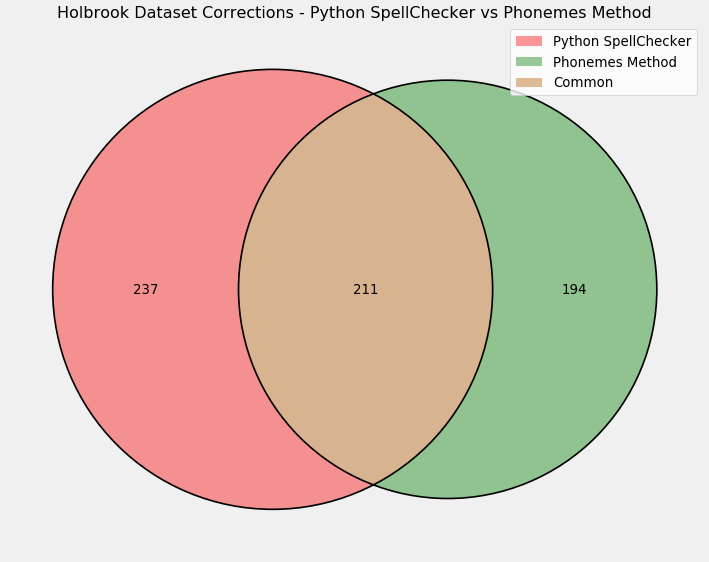

In [22]:
plt.figure(linewidth=5,  facecolor='#F0F0F0', figsize=(15,12), dpi=60)
venn2(subsets=(overlap_holbrook_py_cmu['pyspell'],overlap_holbrook_py_cmu['cmu_phonemes'],
               overlap_holbrook_py_cmu['both']),set_labels=('','',''))
venn2_circles(subsets=(overlap_holbrook_py_cmu['pyspell'],overlap_holbrook_py_cmu['cmu_phonemes'],
               overlap_holbrook_py_cmu['both']))
plt.legend(labels=['Python SpellChecker', 'Phonemes Method','Common'])
plt.title('Holbrook Dataset Corrections - Python SpellChecker vs Phonemes Method')
plt.show()

In [23]:
print(color.BOLD + "Holbrook Overlap PySpell vs CMU Method \n" + color.END)
print_overlap_scores(overlap_holbrook_py_cmu, 'PySpell')

Holbrook Overlap PySpell vs CMU Method 

Total corrections: 642
Overlap corrections: 32.87%
Unique corrections PySpell: 36.92%
Unique corrections Phoneme method: 30.22%


## 2.3 Holbrook Overlap - SymSpell vs Phonemes Method (Phoneme Correction with frequency dictionary)
<a name="holbrook_overlap_symspell_cmu"></a>

In [24]:
overlap_holbrook_sym_cmu = overlap(holbrook_symspell, holbrook_phonemes, 'symspell', 'cmu_phonemes', 
                                   'holbrook','symspell_cmu_phonemes')

In [25]:
overlap_holbrook_sym_cmu

{'both': 209, 'symspell': 220, 'cmu_phonemes': 196}

#### Version 1 Results - No previous use of SymSpell

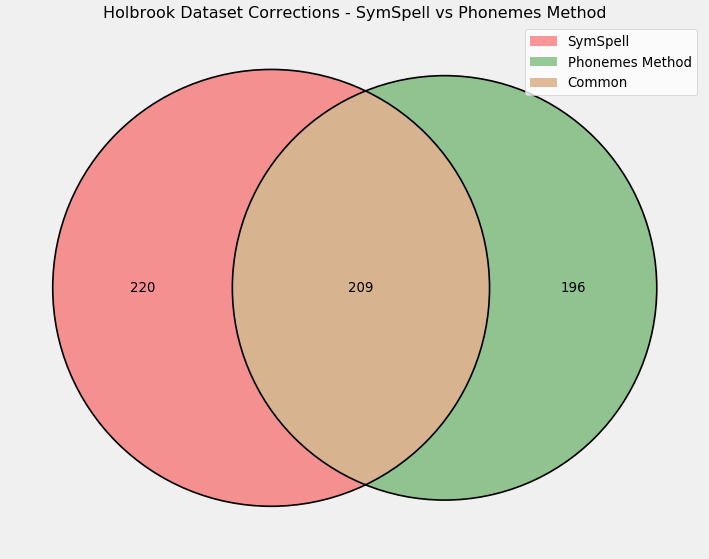

In [26]:
plt.figure(linewidth=5,  facecolor='#F0F0F0', figsize=(15,12), dpi=60)
venn2(subsets=(overlap_holbrook_sym_cmu['symspell'],overlap_holbrook_sym_cmu['cmu_phonemes'],
               overlap_holbrook_sym_cmu['both']),set_labels=('','',''))

venn2_circles(subsets=(overlap_holbrook_sym_cmu['symspell'],overlap_holbrook_sym_cmu['cmu_phonemes'],
               overlap_holbrook_sym_cmu['both']))

plt.legend(labels=['SymSpell', 'Phonemes Method','Common'])
plt.title('Holbrook Dataset Corrections - SymSpell vs Phonemes Method')
plt.show()

In [27]:
print(color.BOLD + "Holbrook Overlap SymSpell vs Phonemes Method \n" + color.END)
print_overlap_scores(overlap_holbrook_sym_cmu, 'SymSpell')

Holbrook Overlap SymSpell vs Phonemes Method 

Total corrections: 625
Overlap corrections: 33.44%
Unique corrections SymSpell: 35.20%
Unique corrections Phoneme method: 31.36%


## 2.4 Holbrook Overlap - Aspell vs Phonemes Method (Phoneme Correction with frequency dictionary)
<a name="holbrook_overlap_aspell_cmu"></a>

In [28]:
overlap_holbrook_asp_cmu = overlap(holbrook_aspell, holbrook_phonemes, 'aspell', 'cmu_phonemes', 
                                   'holbrook','aspell_cmu_phonemes')

In [29]:
overlap_holbrook_asp_cmu

{'both': 204, 'aspell': 209, 'cmu_phonemes': 201}

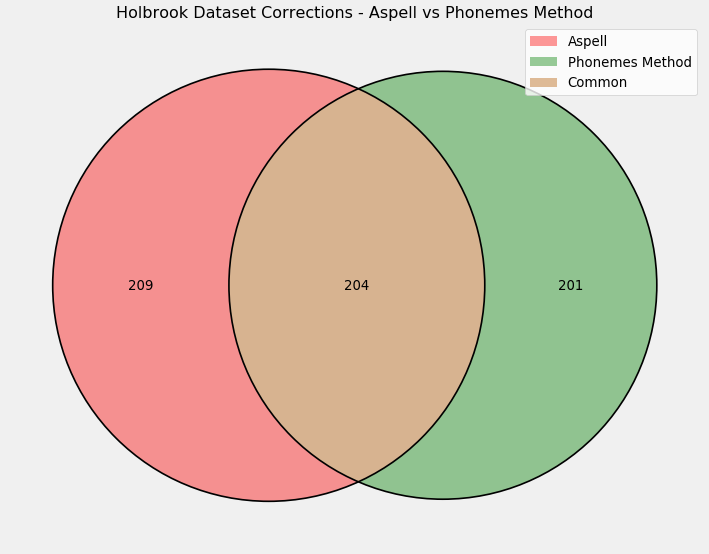

In [30]:
plt.figure(linewidth=5,  facecolor='#F0F0F0', figsize=(15,12), dpi=60)
venn2(subsets=(overlap_holbrook_asp_cmu['aspell'],overlap_holbrook_asp_cmu['cmu_phonemes'],
               overlap_holbrook_asp_cmu['both']),set_labels=('','',''))

venn2_circles(subsets=(overlap_holbrook_asp_cmu['aspell'],overlap_holbrook_asp_cmu['cmu_phonemes'],
               overlap_holbrook_asp_cmu['both']))

plt.legend(labels=['Aspell', 'Phonemes Method','Common'])
plt.title('Holbrook Dataset Corrections - Aspell vs Phonemes Method')
plt.show()

In [32]:
print(color.BOLD + "Holbrook Overlap Aspell vs Phonemes Method \n" + color.END)
print_overlap_scores(overlap_holbrook_asp_cmu, 'Aspell')

Holbrook Overlap Aspell vs Phonemes Method 

Total corrections: 614
Overlap corrections: 33.22%
Unique corrections Aspell: 34.04%
Unique corrections Phoneme method: 32.74%


# 3.0 Birckbeck Dataset <a name="birkbeck"></a>

In [1170]:
# Load Birkbeck Spelling dictionaries
file_name_b_pyspell = Path(input_path_files) / "birkbeck_pyspell_dict.txt"
birkbeck_pyspell = pickle.load(open(file_name_b_pyspell, "rb"))

file_name_b_symspell = Path(input_path_files) / "birkbeck_symspell_dict.txt"
birkbeck_symspell = pickle.load(open(file_name_b_symspell, "rb"))

file_name_b_aspell = Path(input_path_files) / "birkbeck_aspell_dict.txt"
birkbeck_aspell = pickle.load(open(file_name_b_aspell, "rb"))

file_name_b_phonemes = Path(input_path_files) / "birkbeck_phonemes_sym.txt"
birkbeck_phonemes = pickle.load(open(file_name_b_phonemes, "rb"))

## 3.1 Birkbeck Scores <a name="birkbeck_scores"></a>

In [1171]:
df_spellcheck_vs_cmu = pd.DataFrame(columns=['Spelling Application', 'Correct', 'Candidates', 'Correct_and_Candidates'])
results_data = []
results_data.append(score_application('PySpell', birkbeck_pyspell))
results_data.append(score_application('SymSpell', birkbeck_symspell))
results_data.append(score_application('Aspell', birkbeck_aspell))
results_data.append(score_application('Phonemes Method', birkbeck_phonemes))
df_spellcheck_vs_cmu = df_spellcheck_vs_cmu.append(results_data)

In [1172]:
df_spellcheck_vs_cmu

,Spelling Application,Correct,Candidates,Correct_and_Candidates
0,PySpell,11767,2381,14148
1,SymSpell,11773,2811,14584
2,Aspell,13473,8666,22139
3,Phonemes Method,10811,5150,15961


In [1173]:
birkbeck_total_words = len(birkbeck_pyspell)

In [1174]:
scores = assign_scores(df_spellcheck_vs_cmu, 'birkbeck')
print_scores(scores, 'birkbeck', birkbeck_total_words)

PySpell Accuracy: 34.72%
SymSpell Accuracy: 34.74%
Aspell Accuracy: 39.76%
Phoneme Accuracy: 31.9%

PySpell Correct Answer in Candidates List: 7.03%
SymSpell Correct Answer in Candidates List: 8.3%
Aspell Correct Answer in Candidates List: 25.57%
Phoneme Correct Answer in Candidates List: 15.2%

PySpell Recall (Correct + Correct in Candidates List): 41.75%
SymSpell Recall (Correct + Correct in Candidates List): 43.04%
Aspell Recall (Correct + Correct in Candidates List): 65.33%
Phoneme Recall (Correct + Correct in Candidates List): 47.1%


## 3.2 Birkbeck Overlap - PySpell vs Phonemes Method (Phoneme Correction with frequency dictionary)
<a name="birkbeck_overlap_pyspell"></a>

In [1175]:
birkbeck_overlap_py_cmu = overlap(birkbeck_pyspell, birkbeck_phonemes, 'pyspell', 'cmu_phonemes',
                                  'birkbeck', 'pyspell_cmu_phonemes')

In [1176]:
birkbeck_overlap_py_cmu

{'both': 6591, 'pyspell': 5176, 'cmu_phonemes': 4220}

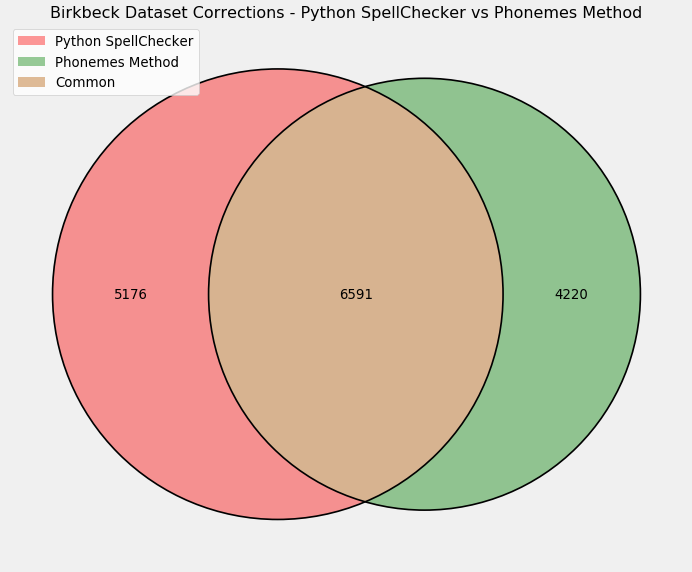

In [1177]:
plt.figure(linewidth=5, facecolor='#F0F0F0', figsize=(15,12), dpi=60)
venn2(subsets=(birkbeck_overlap_py_cmu['pyspell'],birkbeck_overlap_py_cmu['cmu_phonemes'],
               birkbeck_overlap_py_cmu['both']), set_labels=('','',''))

venn2_circles(subsets=(birkbeck_overlap_py_cmu['pyspell'],birkbeck_overlap_py_cmu['cmu_phonemes'],
               birkbeck_overlap_py_cmu['both']))

plt.legend(labels=['Python SpellChecker', 'Phonemes Method','Common'])
plt.title('Birkbeck Dataset Corrections - Python SpellChecker vs Phonemes Method')
plt.show()

In [1178]:
print(color.BOLD + "Birkbeck Overlap PySpell vs CMU Method \n" + color.END)
print_overlap_scores(birkbeck_overlap_py_cmu, 'PySpell')

Birkbeck Overlap PySpell vs CMU Method 

Total corrections: 15987
Overlap corrections: 41.23%
Unique corrections PySpell: 32.38%
Unique corrections Phoneme method: 26.40%


## 3.3 Birkbeck Overlap - SymSpell vs Phonemes Method (Phoneme Correction with frequency dictionary)
<a name="birkbeck_overlap_symspell"></a>

In [1179]:
overlap_birkbeck_sym = overlap(birkbeck_symspell, birkbeck_phonemes, 'symspell', 'cmu_phonemes', 
                               'birkbeck', 'symspell_cmu_phonemes')

In [1180]:
overlap_birkbeck_sym

{'both': 6702, 'symspell': 5071, 'cmu_phonemes': 4109}

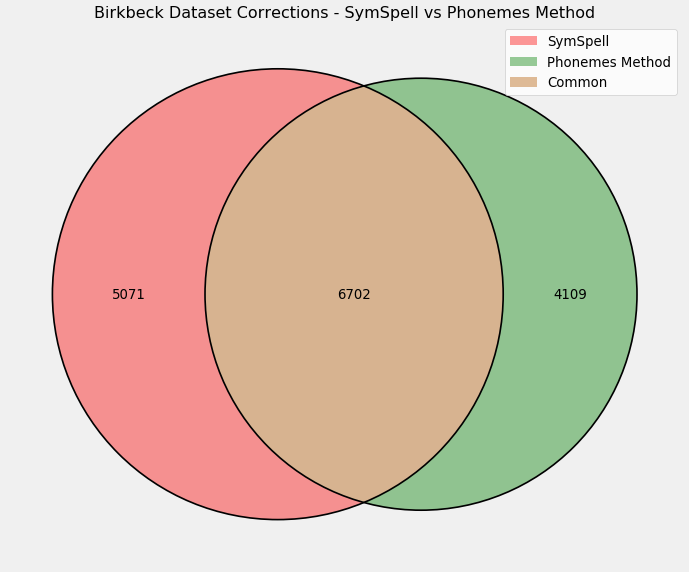

In [1181]:
plt.figure(linewidth=5,  facecolor='#F0F0F0', figsize=(15,12), dpi=60)
venn2(subsets=(overlap_birkbeck_sym['symspell'],overlap_birkbeck_sym['cmu_phonemes'],
               overlap_birkbeck_sym['both']), set_labels=('','',''))

venn2_circles(subsets=(overlap_birkbeck_sym['symspell'],overlap_birkbeck_sym['cmu_phonemes'],
               overlap_birkbeck_sym['both']))

plt.legend(labels=['SymSpell', 'Phonemes Method','Common'])
plt.title('Birkbeck Dataset Corrections - SymSpell vs Phonemes Method')
plt.show()

In [1182]:
print(color.BOLD + "Birkbeck Overlap SymSpell vs CMU Method \n" + color.END)
print_overlap_scores(overlap_birkbeck_sym, 'SymSpell')

Birkbeck Overlap SymSpell vs CMU Method 

Total corrections: 15882
Overlap corrections: 42.20%
Unique corrections SymSpell: 31.93%
Unique corrections Phoneme method: 25.87%


## 3.4 Birkbeck Overlap - Aspell vs Phonemes Method (Phoneme Correction with frequency dictionary)
<a name="birkbeck_overlap_aspell"></a>

In [1183]:
overlap_birkbeck_asp = overlap(birkbeck_aspell, birkbeck_phonemes, 'aspell', 'cmu_phonemes', 
                               'birkbeck', 'aspell_cmu_phonemes')

In [1184]:
overlap_birkbeck_asp

{'both': 7386, 'aspell': 6087, 'cmu_phonemes': 3425}

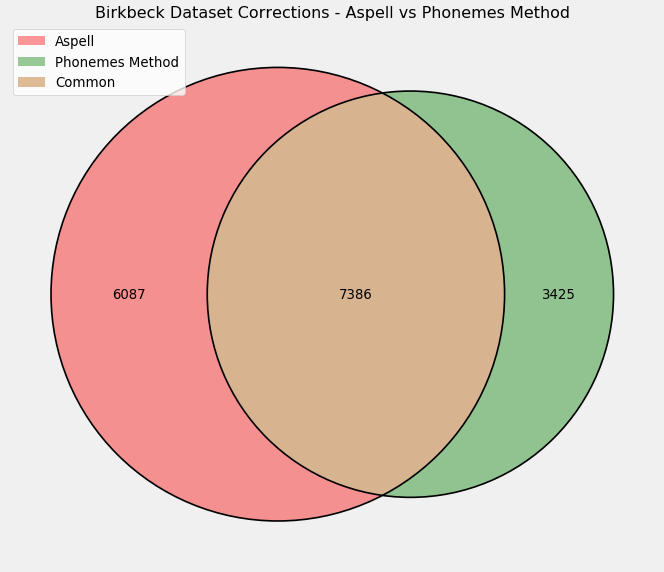

In [1185]:
plt.figure(linewidth=5,  facecolor='#F0F0F0', figsize=(15,12), dpi=60)
venn2(subsets=(overlap_birkbeck_asp['aspell'],overlap_birkbeck_asp['cmu_phonemes'],
               overlap_birkbeck_asp['both']), set_labels=('','',''))

venn2_circles(subsets=(overlap_birkbeck_asp['aspell'],overlap_birkbeck_asp['cmu_phonemes'],
               overlap_birkbeck_asp['both']))

plt.legend(labels=['Aspell', 'Phonemes Method','Common'])
plt.title('Birkbeck Dataset Corrections - Aspell vs Phonemes Method')
plt.show()

In [1186]:
print(color.BOLD + "Birkbeck Overlap Aspell vs Phonemes Method \n" + color.END)
print_overlap_scores(overlap_birkbeck_asp, 'Aspell')

Birkbeck Overlap Aspell vs Phonemes Method 

Total corrections: 16898
Overlap corrections: 43.71%
Unique corrections Aspell: 36.02%
Unique corrections Phoneme method: 20.27%


# 4.0 Zeeko Dataset <a name="zeeko"></a>

In [1187]:
# Load Zeeko Spelling dictionaries
file_name_z_pyspell = Path(input_path_files) / "zeeko_pyspell_dict.txt"
zeeko_pyspell = pickle.load(open(file_name_z_pyspell, "rb"))

file_name_z_symspell = Path(input_path_files) / "zeeko_symspell_dict.txt"
zeeko_symspell = pickle.load(open(file_name_z_symspell, "rb"))

file_name_z_aspell = Path(input_path_files) / "zeeko_aspell_dict.txt"
zeeko_aspell = pickle.load(open(file_name_z_aspell, "rb"))

file_name_z_phonemes = Path(input_path_files) / "zeeko_phonemes_sym.txt"
zeeko_phonemes = pickle.load(open(file_name_z_phonemes, "rb"))

## 4.1 Zeeko Scores <a name="zeeko_scores"></a>

In [1188]:
df_spellcheck_vs_cmu = pd.DataFrame(columns=['Spelling Application', 'Correct', 'Candidates', 'Correct_and_Candidates'])
results_data = []
results_data.append(score_application('PySpell', zeeko_pyspell))
results_data.append(score_application('SymSpell', zeeko_symspell))
results_data.append(score_application('Aspell', zeeko_aspell))
results_data.append(score_application('Phonemes Method', zeeko_phonemes))
df_spellcheck_vs_cmu = df_spellcheck_vs_cmu.append(results_data)

In [1189]:
df_spellcheck_vs_cmu

,Spelling Application,Correct,Candidates,Correct_and_Candidates
0,PySpell,124,29,153
1,SymSpell,127,37,164
2,Aspell,122,62,184
3,Phonemes Method,109,49,158


In [1190]:
zeeko_total_words = len(zeeko_symspell)

In [1191]:
scores = assign_scores(df_spellcheck_vs_cmu, 'zeeko')
print_scores(scores, 'zeeko', zeeko_total_words)

PySpell Accuracy: 53.45%
SymSpell Accuracy: 54.74%
Aspell Accuracy: 52.59%
Phoneme Accuracy: 46.98%

PySpell Correct Answer in Candidates List: 12.5%
SymSpell Correct Answer in Candidates List: 15.95%
Aspell Correct Answer in Candidates List: 26.72%
Phoneme Correct Answer in Candidates List: 21.12%

PySpell Recall (Correct + Correct in Candidates List): 65.95%
SymSpell Recall (Correct + Correct in Candidates List): 70.69%
Aspell Recall (Correct + Correct in Candidates List): 79.31%
Phoneme Recall (Correct + Correct in Candidates List): 68.1%


## 4.2 Zeeko Overlap - PySpell vs Phonemes Method (Phoneme Correction with frequency dictionary)
<a name="zeeko_overlap_pyspell"></a>

In [1192]:
path = "../data_analysis/results/zeeko/symspell_cmu_phonemes/all_cmu_corrections.csv"
path = Path(path)
df_zeeko = pd.read_csv(path)
temp_correct = df_zeeko['suggested'].tolist()

In [1193]:
overlap_zeeko_py = overlap(zeeko_pyspell, zeeko_phonemes, 'pyspell', 'cmu_phonemes', 'zeeko', 
                           'pyspell_cmu_phonemes')

In [1194]:
overlap_zeeko_py

{'both': 76, 'pyspell': 48, 'cmu_phonemes': 33}

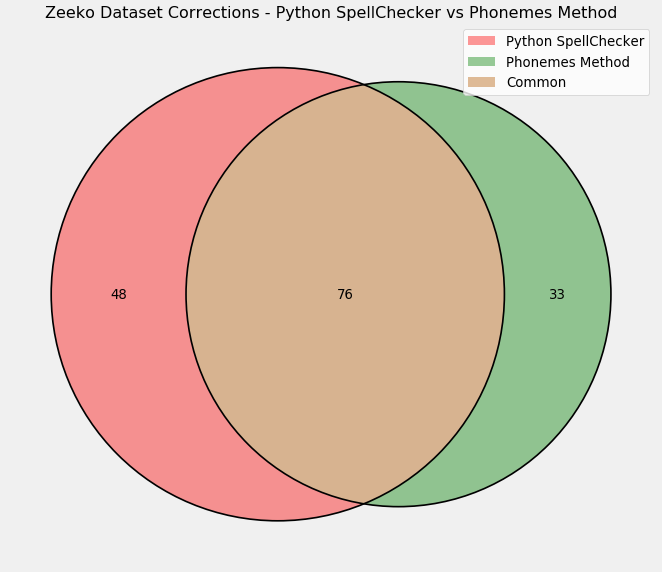

In [1195]:
plt.figure(linewidth=5, facecolor='#F0F0F0', figsize=(15,12), dpi=60)
venn2(subsets=(overlap_zeeko_py['pyspell'],overlap_zeeko_py['cmu_phonemes'],overlap_zeeko_py['both']), 
      set_labels=('','',''))

venn2_circles(subsets=(overlap_zeeko_py['pyspell'],overlap_zeeko_py['cmu_phonemes'],overlap_zeeko_py['both']))

plt.legend(labels=['Python SpellChecker', 'Phonemes Method','Common'])
plt.title('Zeeko Dataset Corrections - Python SpellChecker vs Phonemes Method')
plt.show()

In [1196]:
print(color.BOLD + "Zeeko Overlap PySpell vs CMU Method \n" + color.END)
print_overlap_scores(overlap_zeeko_py, 'PySpell')

Zeeko Overlap PySpell vs CMU Method 

Total corrections: 157
Overlap corrections: 48.41%
Unique corrections PySpell: 30.57%
Unique corrections Phoneme method: 21.02%


## 4.3 Zeeko Overlap - SymSpell vs Phonemes Method (Phoneme Correction with frequency dictionary)
<a name="zeeko_overlap_symspell"></a>

In [1197]:
overlap_zeeko_sym = overlap(zeeko_symspell, zeeko_phonemes, 'symspell', 'cmu_phonemes', 'zeeko',
                            'symspell_cmu_phonemes')

In [1198]:
overlap_zeeko_sym

{'both': 80, 'symspell': 47, 'cmu_phonemes': 29}

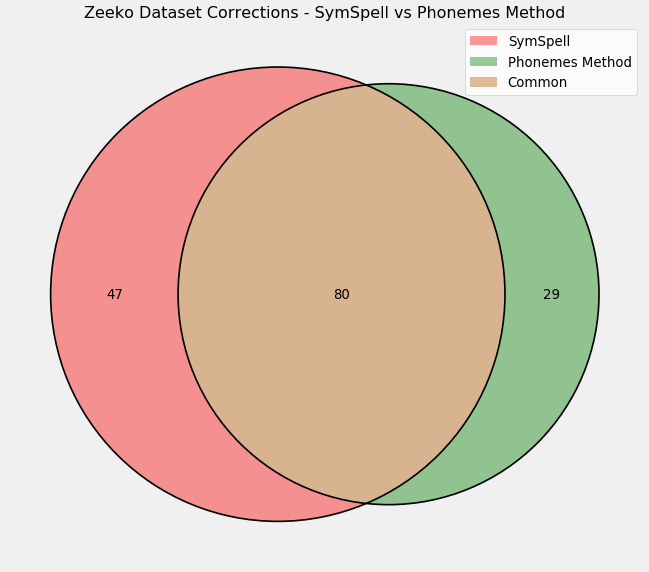

In [1199]:
plt.figure(linewidth=5,  facecolor='#F0F0F0', figsize=(15,12), dpi=60)
venn2(subsets=(overlap_zeeko_sym['symspell'],overlap_zeeko_sym['cmu_phonemes'],overlap_zeeko_sym['both']), 
      set_labels=('','',''))

venn2_circles(subsets=(overlap_zeeko_sym['symspell'],overlap_zeeko_sym['cmu_phonemes'],overlap_zeeko_sym['both']))

plt.legend(labels=['SymSpell', 'Phonemes Method','Common'])
plt.title('Zeeko Dataset Corrections - SymSpell vs Phonemes Method')
plt.show()

In [1200]:
print(color.BOLD + "Zeeko Overlap SymSpell vs CMU Method \n" + color.END)
print_overlap_scores(overlap_zeeko_sym, 'SymSpell')

Zeeko Overlap SymSpell vs CMU Method 

Total corrections: 156
Overlap corrections: 51.28%
Unique corrections SymSpell: 30.13%
Unique corrections Phoneme method: 18.59%


## 4.4 Zeeko Overlap - Aspell vs Phonemes Method (Phoneme Correction with frequency dictionary)
<a name="zeeko_overlap_aspell"></a>

In [1201]:
overlap_zeeko_asp = overlap(zeeko_aspell, zeeko_phonemes, 'aspell', 'cmu_phonemes', 'zeeko',
                            'aspell_cmu_phonemes')

In [1202]:
overlap_zeeko_asp

{'both': 76, 'aspell': 46, 'cmu_phonemes': 33}

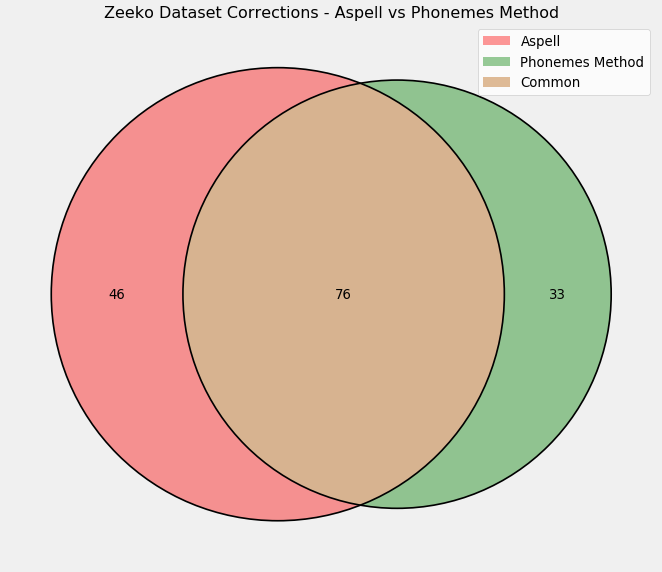

In [1203]:
plt.figure(linewidth=5,  facecolor='#F0F0F0', figsize=(15,12), dpi=60)
venn2(subsets=(overlap_zeeko_asp['aspell'],overlap_zeeko_asp['cmu_phonemes'],overlap_zeeko_asp['both']), 
      set_labels=('','',''))

venn2_circles(subsets=(overlap_zeeko_asp['aspell'],overlap_zeeko_asp['cmu_phonemes'],overlap_zeeko_asp['both']))

plt.legend(labels=['Aspell', 'Phonemes Method','Common'])
plt.title('Zeeko Dataset Corrections - Aspell vs Phonemes Method')
plt.show()

In [1204]:
print(color.BOLD + "Zeeko Overlap Aspell vs CMU Method \n" + color.END)
print_overlap_scores(overlap_zeeko_asp, 'Aspell')

Zeeko Overlap Aspell vs CMU Method 

Total corrections: 155
Overlap corrections: 49.03%
Unique corrections Aspell: 29.68%
Unique corrections Phoneme method: 21.29%


# 5.0 Aspell Dataset <a name="aspell"></a>

In [1205]:
# Load aspell Spelling dictionaries
file_name_a_pyspell = Path(input_path_files) / "aspell_pyspell_dict.txt"
aspell_pyspell = pickle.load(open(file_name_a_pyspell, "rb"))

file_name_a_symspell = Path(input_path_files) / "aspell_symspell_dict.txt"
aspell_symspell = pickle.load(open(file_name_a_symspell, "rb"))

file_name_a_aspell = Path(input_path_files) / "aspell_aspell_dict.txt"
aspell_aspell = pickle.load(open(file_name_a_aspell, "rb"))

file_name_a_phonemes = Path(input_path_files) / "aspell_phonemes_sym.txt"
aspell_phonemes = pickle.load(open(file_name_a_phonemes, "rb"))

## 5.1 Aspell Scores <a name="aspell_scores"></a>

In [1206]:
df_spellcheck_vs_cmu = pd.DataFrame(columns=['Spelling Application', 'Correct', 'Candidates', 'Correct_and_Candidates'])
results_data = []
results_data.append(score_application('PySpell', aspell_pyspell))
results_data.append(score_application('SymSpell', aspell_symspell))
results_data.append(score_application('Aspell', aspell_aspell))
results_data.append(score_application('Phonemes Method', aspell_phonemes))
df_spellcheck_vs_cmu = df_spellcheck_vs_cmu.append(results_data)

In [1207]:
df_spellcheck_vs_cmu

,Spelling Application,Correct,Candidates,Correct_and_Candidates
0,PySpell,250,65,315
1,SymSpell,274,72,346
2,Aspell,286,155,441
3,Phonemes Method,228,85,313


In [1208]:
aspell_total_words = len(aspell_phonemes)

In [1209]:
scores = assign_scores(df_spellcheck_vs_cmu, 'aspell')
print_scores(scores, 'aspell', aspell_total_words)

PySpell Accuracy: 48.54%
SymSpell Accuracy: 53.2%
Aspell Accuracy: 55.53%
Phoneme Accuracy: 44.27%

PySpell Correct Answer in Candidates List: 12.62%
SymSpell Correct Answer in Candidates List: 13.98%
Aspell Correct Answer in Candidates List: 30.1%
Phoneme Correct Answer in Candidates List: 16.5%

PySpell Recall (Correct + Correct in Candidates List): 61.17%
SymSpell Recall (Correct + Correct in Candidates List): 67.18%
Aspell Recall (Correct + Correct in Candidates List): 85.63%
Phoneme Recall (Correct + Correct in Candidates List): 60.78%


## 5.2 Aspell Overlap - PySpell vs Phonemes Method (Phoneme Correction with frequency dictionary)
<a name="aspell_overlap_pyspell_cmu"></a>

In [1210]:
overlap_aspell_py = overlap(aspell_pyspell, aspell_phonemes, 'pyspell', 'cmu_phonemes', 'aspell',
                            'pyspell_cmu_phonemes')

In [1211]:
overlap_aspell_py

{'both': 143, 'pyspell': 107, 'cmu_phonemes': 85}

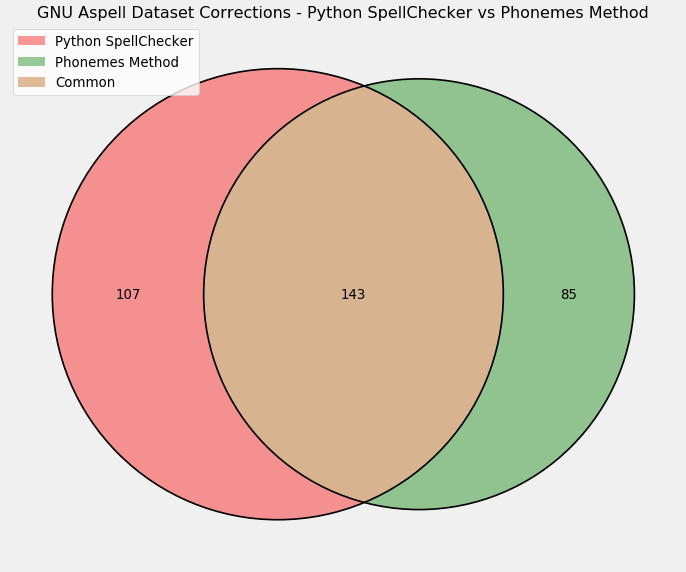

In [1212]:
plt.figure(linewidth=5, facecolor='#F0F0F0', figsize=(15,12), dpi=60)
venn2(subsets=(overlap_aspell_py['pyspell'],overlap_aspell_py['cmu_phonemes'],
               overlap_aspell_py['both']), set_labels=('','',''))

venn2_circles(subsets=(overlap_aspell_py['pyspell'],overlap_aspell_py['cmu_phonemes'],
               overlap_aspell_py['both']))

plt.legend(labels=['Python SpellChecker', 'Phonemes Method','Common'])
plt.title('GNU Aspell Dataset Corrections - Python SpellChecker vs Phonemes Method')
plt.show()

In [1213]:
print(color.BOLD + "Aspell Overlap PySpell vs CMU Method \n" + color.END)
print_overlap_scores(overlap_aspell_py, 'PySpell')

Aspell Overlap PySpell vs CMU Method 

Total corrections: 335
Overlap corrections: 42.69%
Unique corrections PySpell: 31.94%
Unique corrections Phoneme method: 25.37%


## 5.3 Aspell Overlap - SymSpell vs Phonemes Method (Phoneme Correction with frequency dictionary)
<a name="aspell_overlap_symspell_cmu"></a>

In [1214]:
overlap_aspell_sym = overlap(aspell_symspell, aspell_phonemes, 'symspell', 'cmu_phonemes', 'aspell', 
                             'symspell_cmu_phonemes')

In [1215]:
overlap_aspell_sym

{'both': 162, 'symspell': 112, 'cmu_phonemes': 66}

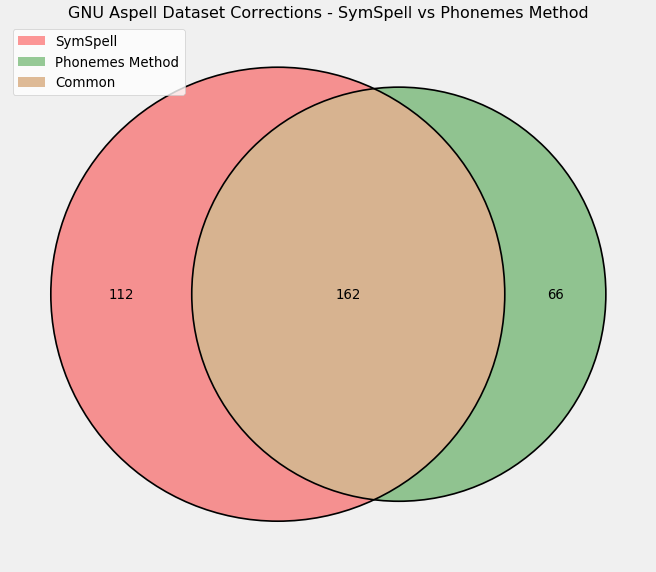

In [1216]:
plt.figure(linewidth=5,  facecolor='#F0F0F0', figsize=(15,12), dpi=60)
venn2(subsets=(overlap_aspell_sym['symspell'],overlap_aspell_sym['cmu_phonemes'],overlap_aspell_sym['both']),
      set_labels=('','',''))

venn2_circles(subsets=(overlap_aspell_sym['symspell'],overlap_aspell_sym['cmu_phonemes'],overlap_aspell_sym['both']))

plt.legend(labels=['SymSpell', 'Phonemes Method','Common'])
plt.title('GNU Aspell Dataset Corrections - SymSpell vs Phonemes Method')
plt.show()

In [1217]:
print(color.BOLD + "Aspell Overlap SymSpell vs CMU Method \n" + color.END)
print_overlap_scores(overlap_aspell_sym, 'SymSpell')

Aspell Overlap SymSpell vs CMU Method 

Total corrections: 340
Overlap corrections: 47.65%
Unique corrections SymSpell: 32.94%
Unique corrections Phoneme method: 19.41%


## 5.4 Aspell Overlap - Aspell vs Phonemes Method (Phoneme Correction with frequency dictionary)
<a name="aspell_overlap_aspell_cmu"></a>

In [1218]:
overlap_aspell_asp = overlap(aspell_aspell, aspell_phonemes, 'aspell', 'cmu_phonemes', 'aspell', 
                             'aspell_cmu_phonemes')

In [1219]:
overlap_aspell_asp

{'both': 169, 'aspell': 117, 'cmu_phonemes': 59}

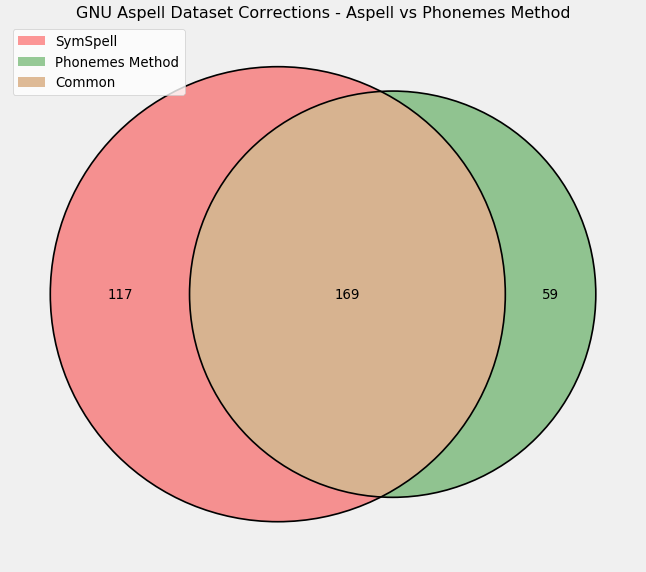

In [1220]:
plt.figure(linewidth=5,  facecolor='#F0F0F0', figsize=(15,12), dpi=60)
venn2(subsets=(overlap_aspell_asp['aspell'],overlap_aspell_asp['cmu_phonemes'],overlap_aspell_asp['both']),
      set_labels=('','',''))

venn2_circles(subsets=(overlap_aspell_asp['aspell'],overlap_aspell_asp['cmu_phonemes'],overlap_aspell_asp['both']))

plt.legend(labels=['SymSpell', 'Phonemes Method','Common'])
plt.title('GNU Aspell Dataset Corrections - Aspell vs Phonemes Method')
plt.show()

In [1221]:
print(color.BOLD + "Aspell Overlap Aspell vs CMU Method \n" + color.END)
print_overlap_scores(overlap_aspell_asp, 'Aspell')

Aspell Overlap Aspell vs CMU Method 

Total corrections: 345
Overlap corrections: 48.99%
Unique corrections Aspell: 33.91%
Unique corrections Phoneme method: 17.10%


# 6.0 Wikipedia Dataset <a name="wiki"><a/>

In [1222]:
# Load wiki Spelling dictionaries
file_name_w_pyspell = Path(input_path_files) / "wiki_pyspell_dict.txt"
wiki_pyspell = pickle.load(open(file_name_w_pyspell, "rb"))

file_name_w_symspell = Path(input_path_files) / "wiki_symspell_dict.txt"
wiki_symspell = pickle.load(open(file_name_w_symspell, "rb"))

file_name_w_aspell = Path(input_path_files) / "wiki_aspell_dict.txt"
wiki_aspell = pickle.load(open(file_name_w_aspell, "rb"))

file_name_w_phonemes = Path(input_path_files) / "wiki_phonemes_sym.txt"
wiki_phonemes = pickle.load(open(file_name_w_phonemes, "rb"))

## 6.1 Wikipedia Scores <a name="wiki_scores"></a>

In [1223]:
df_spellcheck_vs_cmu = pd.DataFrame(columns=['Spelling Application', 'Correct', 'Candidates', 'Correct_and_Candidates'])
results_data = []
results_data.append(score_application('PySpell', wiki_pyspell))
results_data.append(score_application('SymSpell', wiki_symspell))
results_data.append(score_application('Aspell', wiki_aspell))
results_data.append(score_application('Phonemes Method', wiki_phonemes))
df_spellcheck_vs_cmu = df_spellcheck_vs_cmu.append(results_data)

In [1224]:
df_spellcheck_vs_cmu

,Spelling Application,Correct,Candidates,Correct_and_Candidates
0,PySpell,1740,216,1956
1,SymSpell,1806,248,2054
2,Aspell,1774,304,2078
3,Phonemes Method,1320,271,1591


In [1225]:
wiki_total_words = len(wiki_phonemes)

In [1226]:
scores = assign_scores(df_spellcheck_vs_cmu, 'wiki')
print_scores(scores, 'wiki', wiki_total_words)

PySpell Accuracy: 78.03%
SymSpell Accuracy: 80.99%
Aspell Accuracy: 79.55%
Phoneme Accuracy: 59.19%

PySpell Correct Answer in Candidates List: 9.69%
SymSpell Correct Answer in Candidates List: 11.12%
Aspell Correct Answer in Candidates List: 13.63%
Phoneme Correct Answer in Candidates List: 12.15%

PySpell Recall (Correct + Correct in Candidates List): 87.71%
SymSpell Recall (Correct + Correct in Candidates List): 92.11%
Aspell Recall (Correct + Correct in Candidates List): 93.18%
Phoneme Recall (Correct + Correct in Candidates List): 71.35%


## 6.2 Wikipedia Overlap - PySpell vs Phonemes Method (Phoneme Correction with frequency dictionary)
<a name="wiki_overlap_pyspell"></a>

In [1227]:
overlap_wiki_py = overlap(wiki_pyspell, wiki_phonemes, 'pyspell', 'cmu_phonemes', 'wiki', 
                          'pyspell_cmu_phonemes')

In [1228]:
overlap_wiki_py

{'both': 1088, 'pyspell': 652, 'cmu_phonemes': 232}

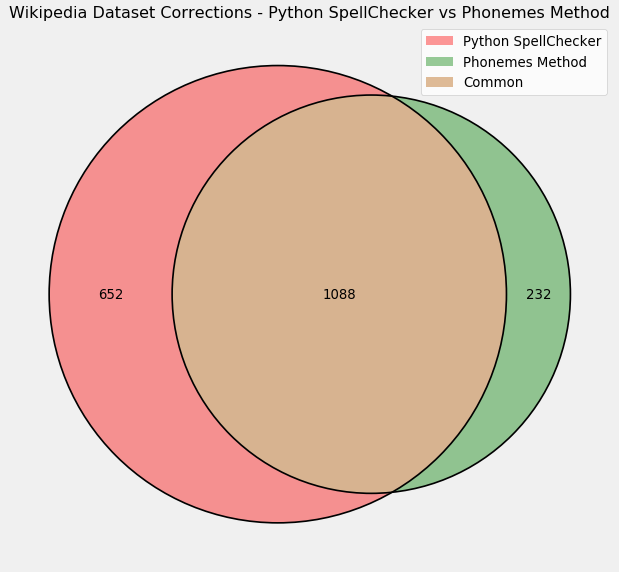

In [1229]:
plt.figure(linewidth=5, facecolor='#F0F0F0', figsize=(15,12), dpi=60)
venn2(subsets=(overlap_wiki_py['pyspell'],overlap_wiki_py['cmu_phonemes'],overlap_wiki_py['both']), set_labels=('','',''))

venn2_circles(subsets=(overlap_wiki_py['pyspell'],overlap_wiki_py['cmu_phonemes'],overlap_wiki_py['both']))

plt.legend(labels=['Python SpellChecker', 'Phonemes Method','Common'])
plt.title('Wikipedia Dataset Corrections - Python SpellChecker vs Phonemes Method')
plt.show()

In [1230]:
print(color.BOLD + "Wikipedia Overlap PySpell vs Phonemes Method \n" + color.END)
print_overlap_scores(overlap_wiki_py, 'PySpell')

Wikipedia Overlap PySpell vs Phonemes Method 

Total corrections: 1972
Overlap corrections: 55.17%
Unique corrections PySpell: 33.06%
Unique corrections Phoneme method: 11.76%


## 6.3 Wikipedia Overlap - SymSpell vs Phonemes Method (Phoneme Correction with frequency dictionary)
<a name="wiki_overlap_symspell"></a>

In [1231]:
overlap_wiki_sym = overlap(wiki_symspell, wiki_phonemes, 'symspell', 'cmu_phonemes', 'wiki', 
                           'symspell_cmu_phonemes')

In [1232]:
overlap_wiki_sym

{'both': 1137, 'symspell': 669, 'cmu_phonemes': 183}

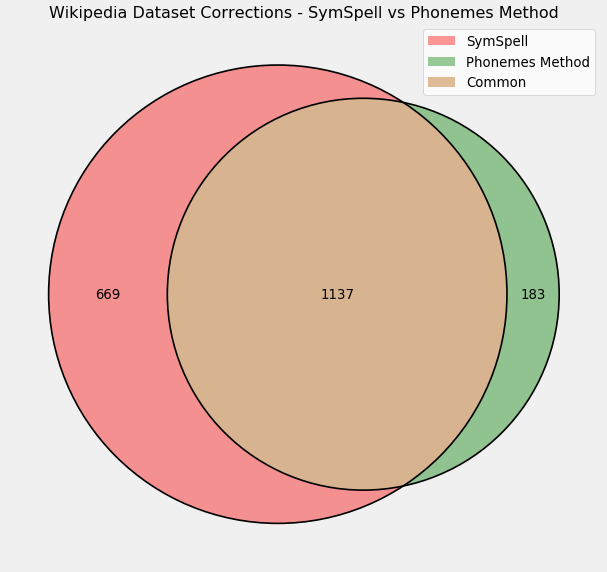

In [1233]:
plt.figure(linewidth=5,  facecolor='#F0F0F0', figsize=(15,12), dpi=60)
venn2(subsets=(overlap_wiki_sym['symspell'],overlap_wiki_sym['cmu_phonemes'],overlap_wiki_sym['both']), 
      set_labels=('','',''))

venn2_circles(subsets=(overlap_wiki_sym['symspell'],overlap_wiki_sym['cmu_phonemes'],overlap_wiki_sym['both']))

plt.legend(labels=['SymSpell', 'Phonemes Method','Common'])
plt.title('Wikipedia Dataset Corrections - SymSpell vs Phonemes Method')


plt.show()

In [1234]:
print(color.BOLD + "Aspell Overlap SymSpell vs Phonemes Method \n" + color.END)
print_overlap_scores(overlap_wiki_sym, 'SymSpell')

Aspell Overlap SymSpell vs Phonemes Method 

Total corrections: 1989
Overlap corrections: 57.16%
Unique corrections SymSpell: 33.63%
Unique corrections Phoneme method: 9.20%


## 6.4 Wikipedia Overlap - Aspell vs Phonemes Method (Phoneme Correction with frequency dictionary)
<a name="wiki_overlap_aspell"></a>

In [1235]:
overlap_wiki_asp = overlap(wiki_aspell, wiki_phonemes, 'aspell', 'cmu_phonemes', 'wiki', 
                           'aspell_cmu_phonemes')

In [1236]:
overlap_wiki_asp

{'both': 1115, 'aspell': 659, 'cmu_phonemes': 205}

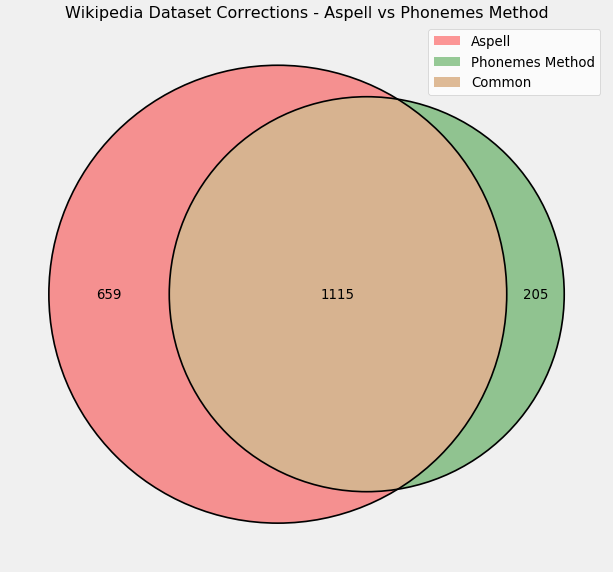

In [1237]:
plt.figure(linewidth=5,  facecolor='#F0F0F0', figsize=(15,12), dpi=60)
venn2(subsets=(overlap_wiki_asp['aspell'],overlap_wiki_asp['cmu_phonemes'],overlap_wiki_asp['both']), 
      set_labels=('','',''))

venn2_circles(subsets=(overlap_wiki_asp['aspell'],overlap_wiki_asp['cmu_phonemes'],overlap_wiki_asp['both']))

plt.legend(labels=['Aspell', 'Phonemes Method','Common'])
plt.title('Wikipedia Dataset Corrections - Aspell vs Phonemes Method')


plt.show()

In [1238]:
print(color.BOLD + "Aspell Overlap Aspell vs Phonemes Method \n" + color.END)
print_overlap_scores(overlap_wiki_asp, 'Aspell')

Aspell Overlap Aspell vs Phonemes Method 

Total corrections: 1979
Overlap corrections: 56.34%
Unique corrections Aspell: 33.30%
Unique corrections Phoneme method: 10.36%
